Inferential statistics
=====

##### Important concepts
* ENG - Electrical Number Group - a grouping used to divide product into rough categories.
* ETIM class - a grouping used to divide products into detailed categories.
* Technical description - a text field describing each product.

In [1]:
# Import packages
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import linregress

%config InlineBackend.figure_format = 'retina'

# Change working directory to get the file
os.chdir('/Users/pkg/Springboard')

# Open pickled file from the data wrangling section and set working directory
with open('data_storytelling.pickle', 'rb') as handle:
    df = pickle.load(handle)
    
os.chdir('/Users/pkg/Springboard/Intermediate Data Science with Python/Python_Capstone')

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# A quick reminder of what the dataset looks like
df.describe()

,EN_group,ETIM_class,Technical_description
count,201274,201274,201274
unique,41,1813,109426
top,43,EC000042,"Spasial serien består av stål Bokser typeS44,S..."
freq,20721,5630,1772


In [3]:
# Five most popular ETIM-classes, with corresponding ENG and frequency
grouped = pd.DataFrame(df.groupby(['EN_group', 'ETIM_class']).size())
grouped.columns = ['freq']
grouped = grouped.sort_values(['freq'],ascending=False)

print(grouped.shape)
grouped.head()

(3803, 1)


freq
EN_group ETIM_class      
16       EC000042    5615
10       EC003250    5146
         EC003248    4819
43       EC000228    3210
10       EC003251    2845

Let's take a closer look at the sets of words from these five ETIM-classes; what would be the dictionaries for the machine learning later. For now, I'll compare the first five, to see if the number of words within each are more or less the same, or if there are any patterns here.

In [4]:
# Number of words in the technical descriptions of the most popular ETIM-class
text1 = df[df['ETIM_class'] == 'EC000042']['Technical_description']
vectorizer1 = CountVectorizer()
vectorizer1.fit(text1)
x1 = vectorizer1.transform(text1)
x1 = x1.toarray()

# Number of words in the technical descriptions of the second most popular ETIM-class
text2 = df[df['ETIM_class'] == 'EC003250']['Technical_description']
vectorizer2 = CountVectorizer()
vectorizer2.fit(text2)
x2 = vectorizer2.transform(text2)
x2 = x2.toarray()

# Number of words in the technical descriptions of the third most popular ETIM-class
text3 = df[df['ETIM_class'] == 'EC003248']['Technical_description']
vectorizer3 = CountVectorizer()
vectorizer3.fit(text3)
x3 = vectorizer3.transform(text3)
x3 = x3.toarray()

# Number of words in the technical descriptions of the fourth most popular ETIM-class
text4 = df[df['ETIM_class'] == 'EC000228']['Technical_description']
vectorizer4 = CountVectorizer()
vectorizer4.fit(text4)
x4 = vectorizer4.transform(text4)
x4 = x4.toarray()

# Number of words in the technical descriptions of the fifth most popular ETIM-class
text5 = df[df['ETIM_class'] == 'EC003251']['Technical_description']
vectorizer5 = CountVectorizer()
vectorizer5.fit(text5)
x5 = vectorizer5.transform(text5)
x5 = x5.toarray()

# Length of the dictionaries
dictionaries_lengths = [len(x1), len(x2), len(x3), len(x4), len(x5)]
dictionaries_lengths

[5630, 5183, 5131, 3211, 2851]

It's not so easy to see any patterns from this alone, let's plot the length of the dictionaries with the number of products for these top five.

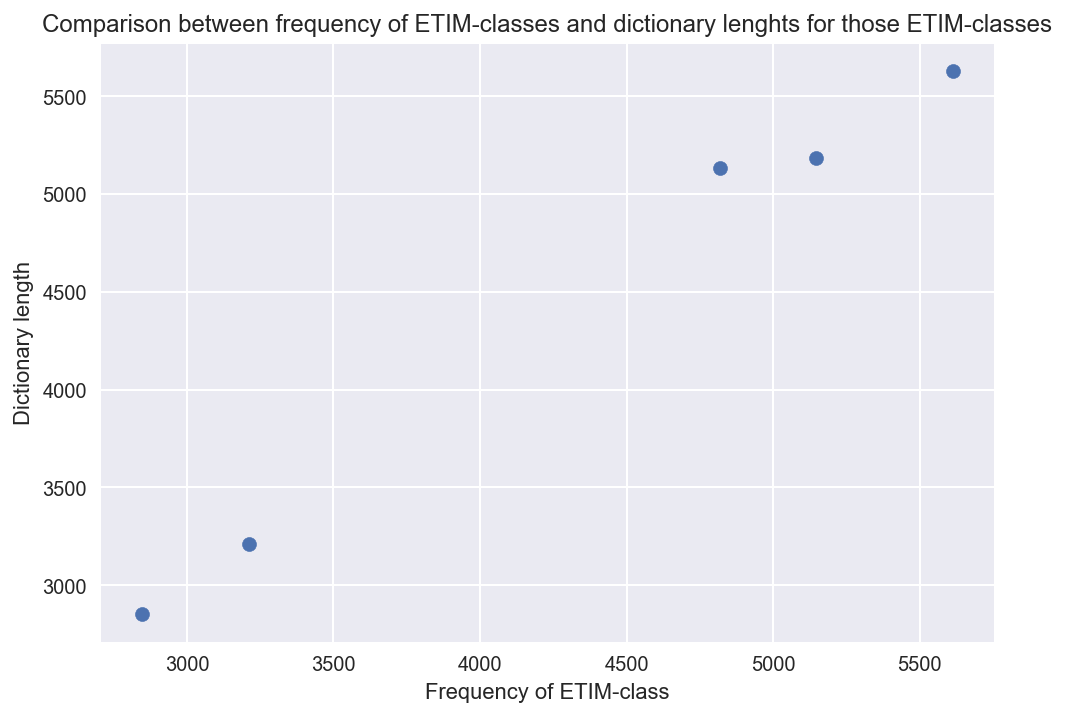

In [5]:
# Scatterplot with the frequencies and dictionary lengths of the five most popular ETIM-classes
plt.scatter(x=grouped.head()['freq'], y=dictionaries_lengths)
plt.xlabel('Frequency of ETIM-class')
plt.ylabel('Dictionary length')
plt.title('Comparison between frequency of ETIM-classes and dictionary lenghts for those ETIM-classes')
plt.show()

Note that the x- and y-axes do not start at zero. From the plot there seems to be a pattern where higher frequency products within an ETIM-class correlates with the dictionary length for that ETIM-class. Perhaps not too surprising, but let's test the correlation between the two.

In [6]:
# Correlation between the two
np.corrcoef(x=grouped.head()['freq'], y=dictionaries_lengths)[0,1]

0.9949476368211202

That's nearly a one-to-one correlation, meaning that when the frequency increases with one, the dictionary lenght increases by almost one. Let's see what a linear regression tells us.

In [7]:
# Ordinary Least Squares regression preparation
X = np.array(grouped.head()['freq'])
Y = np.array(dictionaries_lengths)

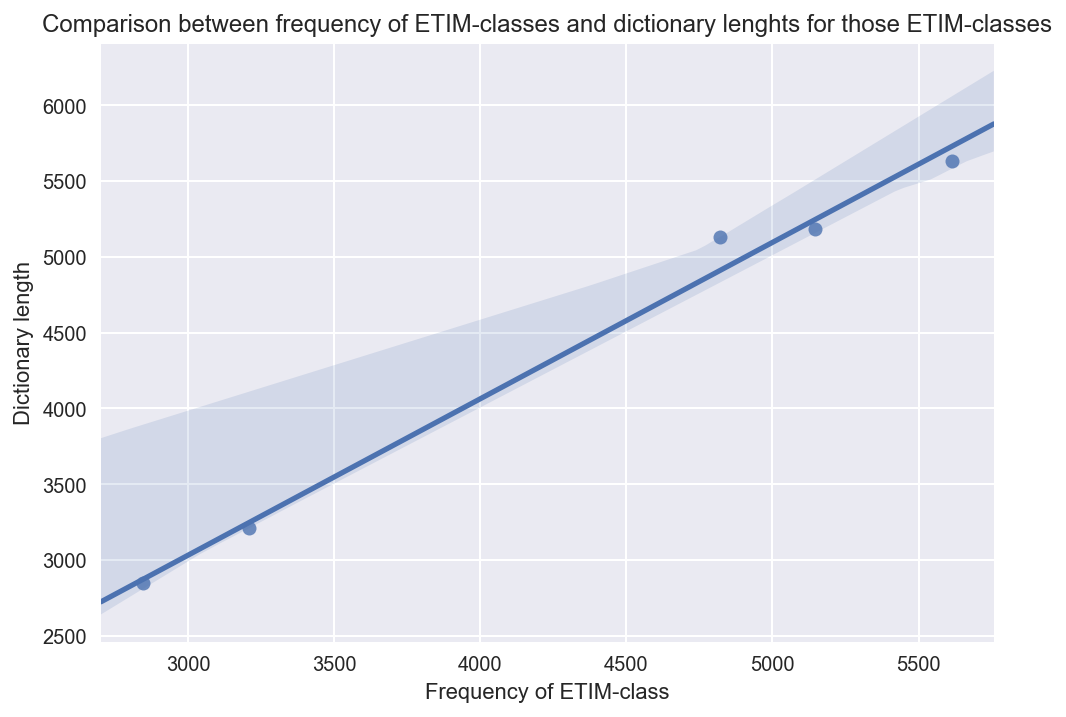

In [8]:
# Plot the fitted line
sns.regplot(X,Y)
plt.xlabel('Frequency of ETIM-class')
plt.ylabel('Dictionary length')
plt.title('Comparison between frequency of ETIM-classes and dictionary lenghts for those ETIM-classes')
plt.show()

In [9]:
# Regression results summary
results = sm.OLS(Y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     6210.
Date:                Wed, 24 Apr 2019   Prob (F-statistic):           1.55e-07
Time:                        13:49:29   Log-Likelihood:                -30.834
No. Observations:                   5   AIC:                             63.67
Df Residuals:                       4   BIC:                             63.28
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0181      0.013     78.804      0.0

/anaconda/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)


The summary shows that again there is an almost one-to-one relationship between the two variables. To be more specific, the regression model predicts that for each increase in frequency (one additional technical description within the selected ETIM-class), the dictionary length is increasing by 1.0181 (just more than one additional token). The p-value is very, very low, which indicates that it is very unlikely that this conclusion was arrived at by chance.